## 3-Way Sentiment Analysis of Amazon Customer Reviews
#### Overview
In this project, we'll build a classification system with a 3-way polarity(Positive, Negative, Neutral) to classify the customer 
reviews of Amazon's Grocery and Gourmet Food platform.

we'll first create a structured database from our raw data which is in an unstructured json format, preprocess it using <b>NLTK</b>
and then deploy <b>Naive Bayes classifier</b> to classify the reviews. we'll also compare the performance of our model against <b>Decision trees</b>
and <b>Support Vector Machines</b>.

#### Data
- The dataset has been taken from Amazon Review Data, Julian McAuley UCSD.
- We have taken 5k customer reviews with ratings in the range of 1-5.

In [1]:
#libraries required 
import json
from pandas import DataFrame
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load the Amazon Grocery and Gourmet Food platform customer reviews dataset
#data = []
#with open('Grocery_and_Gourmet_Food.json') as file:
#    for i in file:
#        if len(data) <= 5000:
#            data.append(json.loads(i))

The actual dataset in json format with 5 million reviews is of 2 Gb size, thus not running this code instead loading the data 
from the csv file created using this data.

## Analysis
## Data Exploration and Visualization
Converting the unstructured data in the json format into a structured database using pandas dataframe so that it can be 
preprocessed and applied to our machine learning model.

In [5]:
# unstructured json file
#data[0:2]

[{'overall': 5.0,
  'verified': True,
  'reviewTime': '06 4, 2013',
  'reviewerID': 'ALP49FBWT4I7V',
  'asin': '1888861614',
  'reviewerName': 'Lori',
  'reviewText': 'Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It definitely will sparkle.',
  'summary': 'Love it',
  'unixReviewTime': 1370304000},
 {'overall': 4.0,
  'verified': True,
  'reviewTime': '05 23, 2014',
  'reviewerID': 'A1KPIZOCLB9FZ8',
  'asin': '1888861614',
  'reviewerName': 'BK Shopper',
  'reviewText': 'Very nicely crafted but too small. Am going to have to add some flowers or something to compensate for the size.',
  'summary': 'Nice but small',
  'unixReviewTime': 1400803200}]

In [6]:
#creating a structured database from the unstructured json file using pandas dataframe
#df = DataFrame(data)
#df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5.0,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly l...,Love it,1370304000,NaN,NaN,NaN
1,4.0,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to...,Nice but small,1400803200,NaN,NaN,NaN
2,4.0,True,"05 9, 2014",A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super p...,"the ""s"" looks like a 5, kina",1399593600,NaN,NaN,NaN
3,5.0,True,"04 20, 2014",A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was ev...",Would recommend this to a friend!,1397952000,NaN,NaN,NaN
4,4.0,True,"04 16, 2014",A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of m...,Topper,1397606400,NaN,NaN,NaN


In [8]:
# save the dataset as a csv file
#df.to_csv(r'C:\Users\user\Desktop\customer_reviews.csv')

In [3]:
df = pd.read_csv('customer_reviews.csv')
df.head(3)

,Unnamed: 0,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,0,5.0,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly l...,Love it,1370304000,NaN,NaN,NaN
1,1,4.0,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to...,Nice but small,1400803200,NaN,NaN,NaN
2,2,4.0,True,"05 9, 2014",A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super p...,"the ""s"" looks like a 5, kina",1399593600,NaN,NaN,NaN


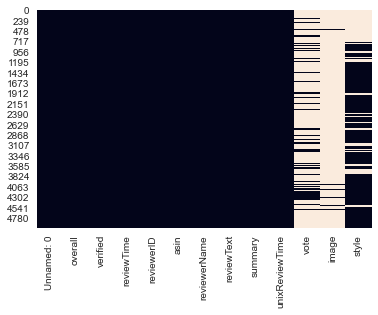

In [6]:
# heatmap showing the presence of null values
sns.heatmap(df.isnull(), cbar=False)

In [7]:
# removing non-relevant columns
df.drop(['Unnamed: 0','reviewerID','asin','reviewerName','summary','unixReviewTime','reviewTime','vote','image','style','verified'], axis=1, inplace=True)

In [8]:
# renaming the columns of our dataset
df = df.rename(columns={"reviewText":"Reviews", "overall":"Rating"})

In [9]:
df.head()

,Rating,Reviews
0,5.0,Very pleased with my purchase. Looks exactly l...
1,4.0,Very nicely crafted but too small. Am going to...
2,4.0,still very pretty and well made...i am super p...
3,5.0,"I got this for our wedding cake, and it was ev..."
4,4.0,It was just what I want to put at the top of m...


In [10]:
#checking for missing values
df.isnull().sum()

Rating     0
Reviews    4
dtype: int64

In [11]:
# we can see the presence of missing values in the Reviews column
df.loc[df['Reviews'].isnull() == True]

,Rating,Reviews
2598,5.0,NaN
3975,5.0,NaN
4120,4.0,NaN
4970,1.0,NaN


In [12]:
# dropping rows with missing values
df.drop(df.index[[2598, 3975, 4120, 4970]], inplace=True)
df.isnull().sum()

Rating     0
Reviews    0
dtype: int64

In [13]:
# reset index of the dataset
df.reset_index(drop=True, inplace=True)

In [14]:
df['Rating'].value_counts()

5.0    3364
4.0     574
3.0     403
1.0     387
2.0     269
Name: Rating, dtype: int64

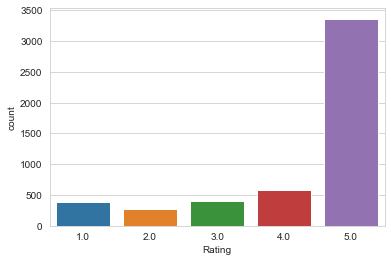

In [15]:
# countplot of Rating
sns.countplot(df['Rating'])

## Methodology
## Data Preprocessing
- Using the Regular Expression (re) package, we'll substitute the special characters in our reviews with a space.
- We'll convert all the letters to lower case.
- We'll split sentences to words.
- We'll remove stopwords and convert each word into it's root form.
- Finally, we'll combine all the reviews separated by a space.

In [46]:
#Data Transformation
ps = PorterStemmer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['Reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [47]:
corpus[0:5]

['pleas purchas look exactli like pictur look great cake definit sparkl',
 'nice craft small go add flower someth compens size',
 'still pretti well made super picki listen whisper look like number',
 'got wed cake everyth even person would recommend anyon',
 'want put top wed cake love true pictur']

In [48]:
stopwords = set(STOPWORDS)

def show_wordcloud(df, title = None):
    wordcloud = WordCloud(
        background_color='White',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(df))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

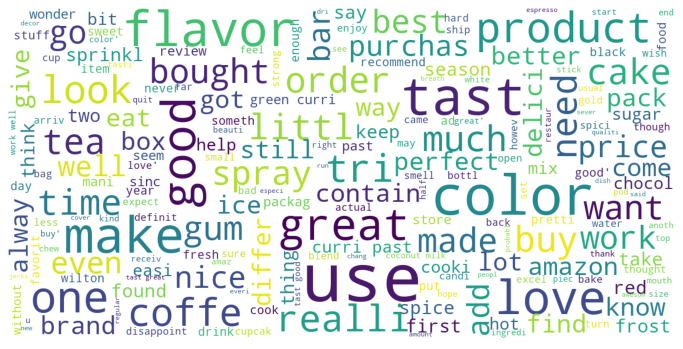

In [49]:
show_wordcloud(corpus)

Now, we'll convert the data into a document matrix where sentences are replaced by a vector which gives the count of each word's 
occurence, this is referred as Bag of words.

In [50]:
#parsing the data into a vector, creating Bag of Words
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Now we'll define the polarity based on the ratings of the reviews
- Positive(4-5) = 1
- Neutral (3)   = 0
- Negative(1-2) = -1

In [51]:
pol = []
for i in df['Rating']:
    if i == 3:
        x = 0 
    elif i > 3:
        x = 1
    else:
        x = -1
    pol.append(x)
    
df['pos_neg'] = pol

In [52]:
y = df['pos_neg']

## Implementation
Splitting the data into a training set and a test set
- Training set will be used the train the Machine Learning Classifiers
- Test set will be used to check the performance of the model on a new dataset

In [53]:
#creating a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Naive Bayes Classifier

In [54]:
#Naive base classifier
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)

y_pred=model.predict(X_test)

In [55]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.818

In [56]:
# Classification report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.59      0.41      0.49       128
           0       0.13      0.04      0.06        71
           1       0.86      0.95      0.90       801

    accuracy                           0.82      1000
   macro avg       0.53      0.47      0.48      1000
weighted avg       0.77      0.82      0.79      1000

[[ 53   5  70]
 [ 13   3  55]
 [ 24  15 762]]


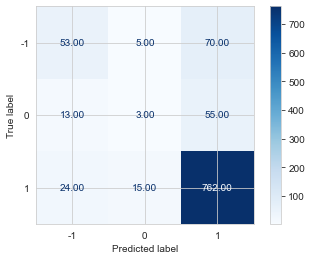

In [57]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, cmap = 'Blues', values_format= '.2f')

The Accuracy of Naive Bayes Classifiers is <b>82%</b>

## Decision Tree 

In [58]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

y_pred2 = clf.predict(X_test)

In [59]:
accuracy_score(y_test,y_pred2)

0.758

In [60]:
print(classification_report(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))

              precision    recall  f1-score   support

          -1       0.46      0.40      0.43       128
           0       0.14      0.17      0.15        71
           1       0.86      0.87      0.87       801

    accuracy                           0.76      1000
   macro avg       0.49      0.48      0.48      1000
weighted avg       0.76      0.76      0.76      1000

[[ 51  16  61]
 [ 10  12  49]
 [ 49  57 695]]


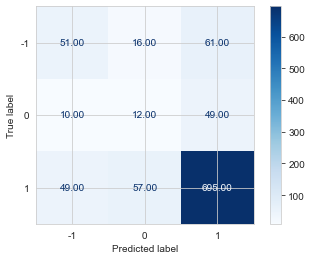

In [61]:
plot_confusion_matrix(clf, X_test, y_test, cmap = 'Blues', values_format= '.2f')

The Accuracy of Decsion Tree Classifier is <b>76%</b>

## Support Vector Machines

In [62]:
#Support vector machines
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
svc.fit(X_train,y_train)

y_pred3 = svc.predict(X_test)

In [63]:
# Accuracy
accuracy_score(y_test,y_pred3)

0.79

In [64]:
print(classification_report(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))

              precision    recall  f1-score   support

          -1       0.48      0.48      0.48       128
           0       0.24      0.24      0.24        71
           1       0.89      0.89      0.89       801

    accuracy                           0.79      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.79      0.79      0.79      1000

[[ 62  16  50]
 [ 14  17  40]
 [ 53  37 711]]


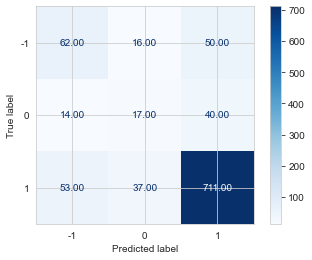

In [65]:
plot_confusion_matrix(svc, X_test, y_test, cmap = 'Blues', values_format= '.2f')

The Accuarcy of Support Vector Machines is <b>79%</b>

## Result
The classifier which is performing well on our data among the three is Naive Bayes Classifier with an Accuracy of 81%.

## Conclusion
This Concludes our project of Sentiment Analysis with a note that the accuarcy of our models can be improved by creating a balanced dataset.